In [1]:
import pandas as pd
import pyodbc
import numpy as np

class get_df:

    def __init__(self):
        self.DB_infos = {"X01" : ("192.168.1.16", "X01", "cm23357868", "86875332")}
        self.querys = {}
        self.db = str()
        self.df_dict =  dict()
        self.w_code_dict = dict()
        self.point_dict = dict()
        self.result_dict = dict()
        
    def db_connect(self, DB_info):
        DB_Host, DB_Name, DB_User, DB_Password = self.DB_infos[DB_info]
        print("Connecting to database using pyodbc...")
        self.db = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server}; SERVER=' + DB_Host + '; DATABASE=' + DB_Name + '; UID=' + DB_User + '; PWD=' + DB_Password)
        print("Succesfully Connected to database using pyodbc!")
      
    def load_data(self, query):
        df =  pd.read_sql(self.querys[query], self.db)
        return df
    @staticmethod
    def make_ESM():
        df = """SELECT    [日期]
                         ,[代號]
                         ,[名稱]
                         ,[最高買價]
                         ,[最低賣價]
                         ,[開盤價]
                         ,[最高價]
                         ,[最低價]
                         ,[收盤價]
                         ,[前日均價]
                         ,[本日均價]
                         ,[漲跌]
                         ,[漲幅(%)]
                         ,[成交量]
                         ,[成交金額(千)]
                         ,[成交筆數]
                         ,[股本(百萬)]
                         ,[股本(股)]
                         ,[總市值(億)]
                         ,[市值比重(%)]
                         ,[成交量(股)]
                         ,[成交金額(元)]
                         ,[系統外議價最高價]
                         ,[系統外議價最低價]
                         ,[系統外議價成交均價]
                         ,[系統外議價成交量(股)]
                         ,[系統外議價成交金額(千)]
                         ,[系統外議價成交筆數]
                         ,[RTIME]
                     
                    FROM [X01].[dbo].[興櫃日收盤]  where 日期 >= 20020101 order by 日期"""
        return df

In [2]:
sql_base = get_df()
sql_base.db_connect('X01')
sql_base.querys['ESM'] = sql_base.make_ESM()

Connecting to database using pyodbc...
Succesfully Connected to database using pyodbc!


In [3]:
ESM行情表 = sql_base.load_data('ESM')
ESM行情表 = ESM行情表.sort_values(by = ['日期','代號']).reset_index(drop = True)

In [4]:
ESM行情表['日期'] = pd.to_datetime(ESM行情表['日期'],format = "%Y%m%d").fillna(0)
ESM行情表 = ESM行情表.set_index('日期')

In [5]:
ESM1 = pd.Series(ESM行情表['代號'])
ESMlist = ESM1.sort_values().drop_duplicates()
ESMlist = list(ESMlist)

In [6]:
from tqdm import tqdm
ESM_dict = {str(ESMlist[i]):ESM行情表[ESM行情表['代號'] == ESMlist[i]] for i in tqdm(range(len(ESMlist)))}

100%|██████████| 1712/1712 [01:57<00:00, 14.52it/s]


In [7]:
feature_ls = ESM行情表.columns[2:]
ESM行情表 = ESM行情表.reset_index(drop = False)
data_pivots_ls = []
for feature in tqdm(ESM行情表.columns[2:]):
    data_pivot = ESM行情表.pivot('日期','代號',feature)
    data_pivots_ls.append(data_pivot)

100%|██████████| 27/27 [00:11<00:00,  2.42it/s]


In [8]:
pivot_dict = {str(ESM行情表.columns[2:][i]):data_pivots_ls[i] for i in range(len(ESM行情表.columns[2:]))}

ESM_dict.update(pivot_dict)

In [9]:
ESMDDW = {}
for j in tqdm(ESMlist):
    ESMDDW[str(j)] = ESM_dict[str(j)].resample('W-FRI').agg({'開盤價':'first', '最高價':'max', '最低價':'min', '收盤價':'last', '成交金額(千)':'sum'\
                                                           }).fillna(method = 'pad' ,axis = 0)

100%|██████████| 1712/1712 [00:09<00:00, 178.60it/s]


In [10]:
ESMDDW['4172'].tail(10)

,開盤價,最高價,最低價,收盤價,成交金額(千)
日期,,,,,
2023-11-10,21.000000,21.250000,20.000000,20.299999,20098.0
2023-11-17,20.350000,23.600000,20.000000,22.900000,71193.0
2023-11-24,22.950001,24.000000,21.900000,22.400000,70775.0
2023-12-01,22.400000,23.700001,22.000000,23.400000,48563.0
2023-12-08,23.450001,24.200001,21.000000,21.900000,52881.0
2023-12-15,22.000000,23.950001,17.900000,19.250000,185002.0
2023-12-22,19.450001,19.450001,16.900000,17.150000,70003.0
2023-12-29,17.200001,17.799999,16.100000,17.400000,50609.0
2024-01-05,17.450001,18.200001,16.700001,17.100000,33748.0


100%|██████████| 1712/1712 [02:07<00:00, 13.40it/s]


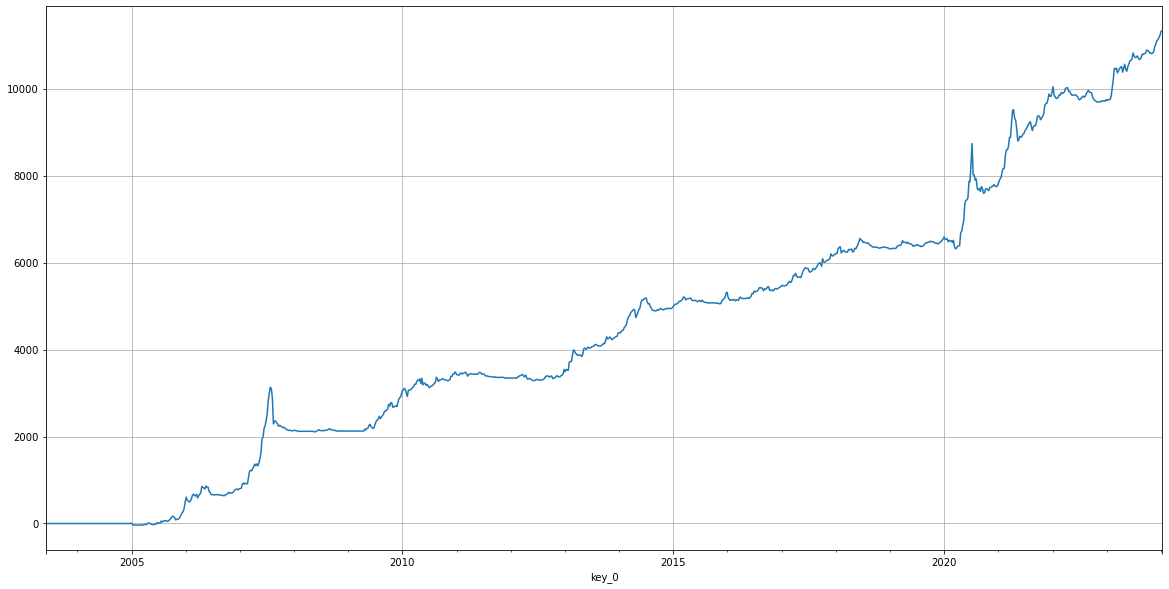

In [11]:
import talib
ERROR = []
trr = pd.DataFrame()
pz = pd.DataFrame()

for x in tqdm(ESMlist):
    
    ESMDDW[str(x)]['MAX52'] = ESMDDW[str(x)]["收盤價"].rolling(52).max()
    ESMDDW[str(x)]["MAX52S"] = ESMDDW[str(x)]["MAX52"].shift(1)
    ESMDDW[str(x)]["4MA"] = talib.MA(ESMDDW[str(x)]["收盤價"].fillna(0), timeperiod=4, matype=0)
    ESMDDW[str(x)]["4MAS"] = ESMDDW[str(x)]["4MA"].shift(1)
    ESMDDW[str(x)]["DR"] = ((ESMDDW[str(x)]["收盤價"] - ESMDDW[str(x)]["收盤價"].shift(1))/ESMDDW[str(x)]["收盤價"].shift(1))*100
    
    
    KPBS = 0
    KPBUY =[]
    for z in range(len(ESMDDW[str(x)])):

        if ESMDDW[str(x)]["收盤價"].iloc[z]  > ESMDDW[str(x)]["MAX52S"].iloc[z] and ESMDDW[str(x)]['成交金額(千)'].iloc[z] > 30000 and ESMDDW[str(x)]['4MA'].iloc[z] > ESMDDW[str(x)]["4MAS"].iloc[z] :
        
            KPBS = 1

        elif  ESMDDW[str(x)]['收盤價'].iloc[z] < ESMDDW[str(x)]['最低價'].rolling(3).min().shift(1).iloc[z] \
         :
            KPBS = 0
            #buy.append("0")
        KPBUY.append(KPBS)
    ESMDDW[str(x)]["KPBUY"] = KPBUY
    ESMDDW[str(x)]["KPBUYS"] = ESMDDW[str(x)]["KPBUY"].shift(1)
    pzb = ESMDDW[str(x)]["KPBUYS"]  
    pzb.name = str(x)
    pzbs = ESMDDW[str(x)]["KPBUY"]
    pzbs.name = str(x)
    ESMDDW[str(x)]["KPRR"] = ESMDDW[str(x)]["DR"] * ESMDDW[str(x)]["KPBUYS"].dropna().astype(int)
    PT = ESMDDW[str(x)]["KPRR"]
    PT.name = str(x)
    if len(trr) == 0:
        trr = PT
    else:
        trr = pd.merge(trr,PT,left_on = trr.index,right_on = PT.index,how = 'outer')
        trr.set_index('key_0',inplace = True)
    if len(pz) == 0:
        pz = pzbs
    else:
        pz = pd.merge(pz,pzbs,left_on = pz.index,right_on = pzbs.index,how = 'outer')
        pz.set_index('key_0',inplace = True)

trrb =(trr*1).replace(np.inf,0).sort_index().sum(axis = 1).cumsum().plot(figsize=(20, 10),grid = True)

11.734200743494425
0.0
55.0


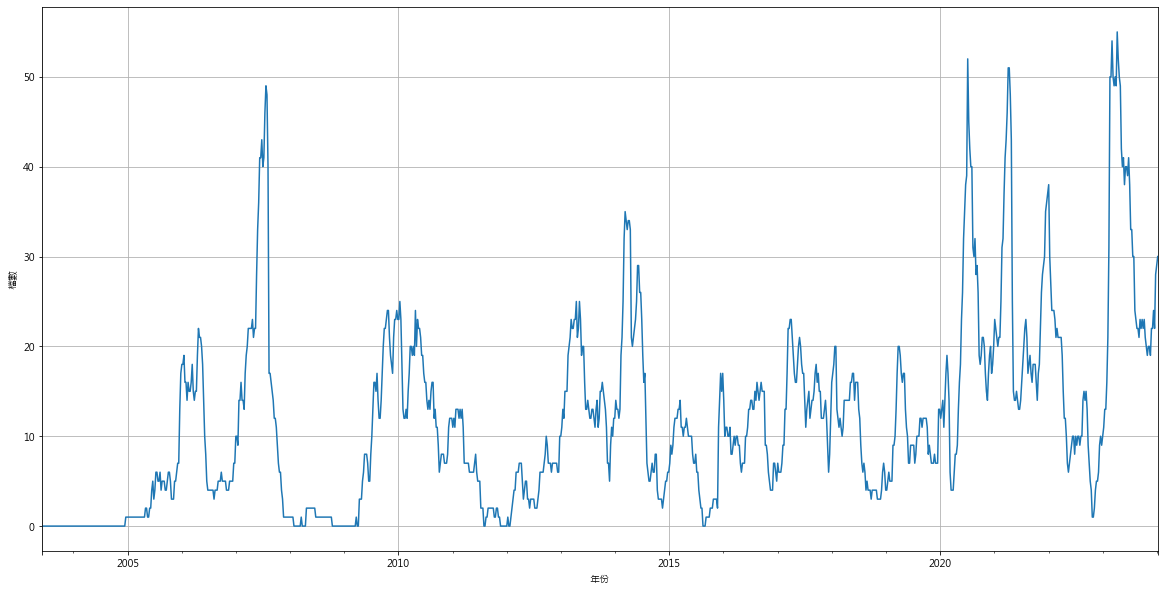

In [12]:
import talib
import matplotlib.pyplot as plt
pz1 = pz.sort_index()
f = lambda x :float(x)
pz2 = pz1.applymap(f)
pz3 = pz2.sum(axis=1)
pz4 = pz3.groupby(pd.Grouper(freq='1W')).tail(1)
plt.rcParams['font.family'] = ['Microsoft JhengHei'] # 中文標籤
plt.rcParams['axes.unicode_minus'] = False # 負號
print(pz4.mean())
print(pz4.min())
print(pz4.max())
pz4.plot(figsize=(20, 10),grid = True)
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig(r'C:\Users\larryx30\larryx30\每週買賣報表\興櫃部位變化.png')

In [13]:
當週日期 = trr.sort_index().index[-1]
前週日期 = trr.sort_index().index[-2]

In [14]:
興櫃持有部位 = pz2.loc[當週日期][(pz2.loc[當週日期]==1)]
興櫃買進 = pz2.loc[當週日期][(pz2.loc[當週日期]==1) & (pz2.loc[前週日期]==0)]
興櫃賣出 = pz2.loc[當週日期][(pz2.loc[當週日期]==0) & (pz2.loc[前週日期]==1)]
print("興櫃買進標的")
print(興櫃買進)
print("興櫃買進檔數" , len(興櫃買進))
print("興櫃持有部位數目" , len(興櫃持有部位))
print("興櫃賣出部位")
print(興櫃賣出)
print("興櫃賣出檔數" , len(興櫃賣出))


興櫃買進標的
6403    1.0
6565    1.0
Name: 2024-01-12 00:00:00, dtype: float64
興櫃買進檔數 2
興櫃持有部位數目 30
興櫃賣出部位
2249    0.0
Name: 2024-01-12 00:00:00, dtype: float64
興櫃賣出檔數 1


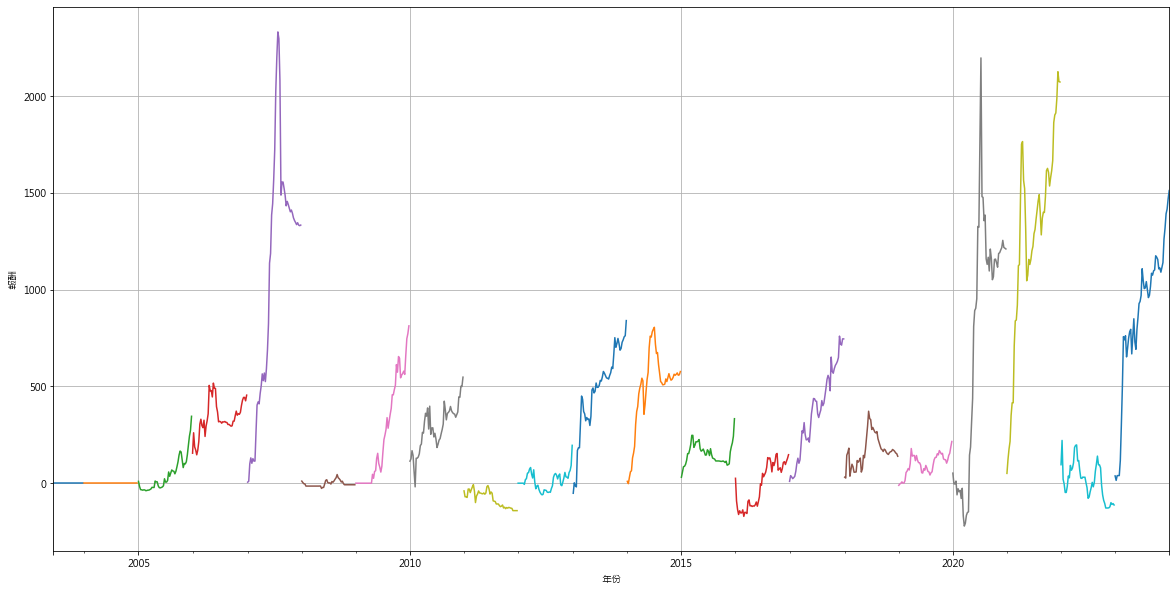

In [15]:
yl = ['2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']
for h in yl :
    trrt = trr.groupby(pd.Grouper(freq='1W')).sum().sum(axis=1)[str(h)].cumsum()
    trrtfig = trrt.plot(figsize=(20, 10),grid = True)
trrtfig = plt.gcf()

plt.xlabel("年份")
plt.ylabel("報酬")
trrtfig.savefig(r'C:\Users\larryx30\larryx30\每週買賣報表\興櫃歷年損益.png')

In [16]:
興櫃持有部位

1271    1.0
1563    1.0
2072    1.0
3633    1.0
4170    1.0
4441    1.0
4738    1.0
4749    1.0
4771    1.0
5262    1.0
5271    1.0
5863    1.0
6403    1.0
6407    1.0
6498    1.0
6565    1.0
6595    1.0
6637    1.0
6699    1.0
6720    1.0
6785    1.0
6812    1.0
6814    1.0
6826    1.0
6906    1.0
6914    1.0
6931    1.0
8045    1.0
8162    1.0
8487    1.0
Name: 2024-01-12 00:00:00, dtype: float64